# WNBA Shot Probability Model

The following marches through the same methodology detailed [here](https://github.com/basketballrelativity/shot_probability/blob/master/shot_probability.ipynb) for an NBA shot probability model. Many factors affect the chances that a field goal attempt will be successful. While not exhaustive, the following list contains a few:

- Shooting ability of the shooter
- Proximity (and number) of the closest defender(s)
- Shot location
- Shot type

The following introduces the `Shots` class of the [py_ball](https://github.com/basketballrelativity/py_ball) package by exploring the `pbp` endpoints of the `data.wnba.com`. The goal of this analysis is to build a shot probability model that outperforms a baseline model.

In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
import itertools

from PIL import Image
import time
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from IPython.display import IFrame

from py_ball import wnba_shots

HEADERS = {'Connection': 'close',
           'Host': 'stats.nba.com',
           'Origin': 'http://stats.nba.com',
           'Upgrade-Insecure-Requests': '1',
           'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_2)' + \
                         'AppleWebKit/537.36 (KHTML, like Gecko) ' + \
                         'Chrome/66.0.3359.117 Safari/537.36'}

pd.options.mode.chained_assignment = None  # Disabling pandas SetWithCopyWarnings

The `Shots` class requires a few parameters:
- season: YYYY season year format
- game_id: The unique identifier for the game of interest

The following pulls play-by-play data for a 2019 preseason game between the Mystics and the Dream.

In [167]:
game_id = '1021900002'
season = '2019'

shots = wnba_shots.Shots(headers=HEADERS,
                         game_id=game_id,
                         season=season)
shot_df = pd.DataFrame(shots.data)
shot_df.head(15)

,cl,de,epid,etype,evt,hs,locX,locY,mtype,oftid,opid,opt1,opt2,ord,pid,tid,vs
0,10:00,Start Period,,12,2,0,0,-80,0,0,,0,0,20000,0,0,0
1,10:00,Jump Ball Charles vs Dupree (Zahui B gains pos...,204320,10,4,0,0,-80,0,1611661313,200676,0,0,60000,202250,1611661313,0
2,09:47,[NYL 2-0] Charles Cutting Layup Shot: Made (2 ...,204320,1,7,2,-14,2,98,1611661313,,2,0,70000,202250,1611661313,0
3,09:32,[IND] Mitchell Turnover : Bad Pass (1 TO) Stea...,,5,9,2,0,166,1,1611661325,204296,1,0,90000,1628909,1611661325,0
4,09:20,[NYL] Nurse 3pt Shot: Missed,,2,11,2,-131,207,1,1611661313,,3,0,110000,1628915,1611661313,0
5,09:15,[IND] Achonwa Rebound (Off:0 Def:1),,4,12,2,-131,207,0,1611661313,,0,0,120000,203831,1611661325,0
6,09:10,[IND] Laney Driving Layup Shot: Missed,,2,13,2,-17,13,6,1611661325,,2,0,130000,204335,1611661325,0
7,09:08,[NYL] Charles Rebound (Off:0 Def:1),,4,14,2,-17,13,0,1611661325,,0,0,140000,202250,1611661313,0
8,09:04,[NYL] Charles Driving Layup Shot: Missed,,2,15,2,-1,22,6,1611661313,,2,0,150000,202250,1611661313,0
9,09:04,[IND] Wheeler Rebound (Off:0 Def:1),,4,16,2,-1,22,0,1611661313,,0,0,160000,204365,1611661325,0


Looks like the `mtype` field encodes the type of shot taken. After reviewing the different values and the corresponding play description, I mapped the different `mtype` values to three shot type: hook shot, layup, and jump shot.  

After observing some of the potential features available, this shot probability model will go forward with the following features:
   - Shot distance
   - Angle to basket (0 degrees is straight on, 45 degrees is baseline)
   - Side of basket
   - Shot type
   
These features are available directly from the `pbp` endpoint, so the following cell contains a function to generate those features.

In [168]:
def feature_engineering(shotchart_df):
    """ feature_engineering calculates engineered
    features from the shotchart data

    @param shotchart_df (DataFrame): DataFrame containing
    shotchart data

    Returns:

        shotchart_df (DataFrame): DataFrame containing
        the engineered features
    """

    hook_codes = [3, 55, 57, 58, 67, 93, 96]
    layup_codes = [5, 6, 7, 40, 41, 42, 43, 44,
                   71, 72, 73, 74, 75, 76, 97,
                   98, 99, 100]
    jump_codes = [1, 2, 45, 46, 47, 63, 66,
                  77, 78, 79, 80, 81, 82, 83,
                  85, 86, 101, 102, 103, 104, 105]
    shotchart_df = shotchart_df[shotchart_df['etype'].isin([1, 2])]

    shotchart_df['SHOT_DISTANCE'] = np.sqrt((shotchart_df['locX']/10.0)**2 +
                                            (shotchart_df['locY']/10.0)**2)
    shotchart_df['ANGLE'] = abs(np.rad2deg(np.arctan2(shotchart_df['locX'],
                                                      shotchart_df['locY'])))

    shotchart_df['SIDE'] = [1 if x >= 0 else 0 for x in shotchart_df['locX']]

    shotchart_df['HOOK'] = [1 if x in hook_codes else 0 for x in shotchart_df['mtype']]
    shotchart_df['LAYUP'] = [1 if x in layup_codes else 0 for x in shotchart_df['mtype']]
    shotchart_df['JUMP'] = [1 if x in jump_codes else 0 for x in shotchart_df['mtype']]
    shotchart_df['SHOT_MADE_FLAG'] = [1 if x == 1 else 0 for x in shotchart_df['etype']]

    shotchart_df = shotchart_df[['SHOT_DISTANCE', 'ANGLE', 'SIDE', 'HOOK', 'LAYUP', 'JUMP', 'SHOT_MADE_FLAG']]

    return shotchart_df

In [169]:
shot_df = feature_engineering(shot_df)

In [170]:
shot_df.head()

,SHOT_DISTANCE,ANGLE,SIDE,HOOK,LAYUP,JUMP,SHOT_MADE_FLAG
2,1.414214,81.869898,0,0,1,0,1
4,24.496939,32.327684,0,0,0,1,0
6,2.140093,52.594643,0,0,1,0,0
8,2.202272,2.602562,0,0,1,0,0
10,15.205262,88.492564,0,0,0,1,0


The above handles the feature engineering of all desired features. Gathering more data would be the next step. The next cell contains functions that pull shot chart data for an entire WNBA regular season. For the sake of time, the 2017 season shotchart data has been pulled and is stored in this repository in the `wnba_shotchart_2017.csv` file.

In [171]:
def pad_id(num):
    """ pad_id adds the requisite number of leading
    zeroes to a game number to form a valid game_id

    @param num (int): Regular season game number

    Returns:

        num_str (str): Regular season game number
        with leading zeroes
    """
    
    num_str = str(num)
    while len(num_str) < 4:
        num_str = '0' + num_str
        
    return num_str


def get_year_shotcharts(year):
    """ get_year_shotcharts pulls data from the
    shotchartdetail endpoint of the stats.nba.com API

    @param year (int): year corresponding to the year
    in which the season began. For example, the 2017-2018
    NBA season is represented as the year 2017.

    Returns:

        Saves a .csv file of the shotchart data to the
        current working directory with a name formatted
        as shotchart_[year].csv
    """

    year_sub = str(year)[-2:]

    base = '102' + year_sub + '0'

    all_df = pd.DataFrame({})

    for x in range(1, 205):
        print('Game #' + str(x))
        game_id_here = base + pad_id(x)
        print(game_id_here)
        t0 = time.time()
        shots = wnba_shots.Shots(headers=HEADERS,
                                 game_id=game_id_here,
                                 season=year)
        shot_df = pd.DataFrame(shots.data)

        delay = time.time() - t0
        print('Waiting ' + str(10*delay) + 's')
        time.sleep(delay)

        all_df = pd.concat([all_df, shot_df], axis=0).reset_index(drop=True)

    all_df.to_csv('wnba_shotchart_'+str(year)+'.csv', index=False)

In [172]:
# get_year_shotcharts(2017)

In [173]:
all_shots_df = pd.read_csv('wnba_shotchart_2017.csv')

In [174]:
features_df = feature_engineering(all_shots_df)

In [175]:
features_df.SHOT_MADE_FLAG.value_counts()

0    15506
1    12219
Name: SHOT_MADE_FLAG, dtype: int64

Looks like the dataset has nearly 30,000 shots! The above shows a fairly even split between made shots (1) and missed shots (0). The following cells build a random forest classifier to predict the probability of a shot going in. First, let's split the dataset into a training and test set.

In [176]:
output = list(features_df['SHOT_MADE_FLAG'])
features_df = features_df.drop(['SHOT_MADE_FLAG'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(features_df, output, test_size=0.1, random_state=489)

Establishing a baseline model provides a basis for comparison to any subsequent models built to assess improvement in prediction. A simple baseline would be to use a constant shooting percentage from the training set.

In [177]:
sum(y_train)/float(len(y_train))

0.44080634818852193

With the above baseline model established, the following uses the `GridSearchCV` function from `sklearn` to perform hyperparameter tuning for the random forest model (`RandomForestClassifier`). 5-fold cross validation searches for the best hyperparameter combination through an exhaustive grid search. The grid search consists of:
- `n_estimators`: number of trees in the random forest
- `min_samples_leaf`: the minimum number of observations to be included in a leaf node
- `max_depth`: the maximum depth of a tree within the forest

Note, the grid search is time consuming as each combination of parameters is explored via cross validation. For the sake of time, the optimal parameters resulting from the cross validation are provided.

In [178]:
parameters = {'n_estimators':[250],
              'max_depth': [7],
              'min_samples_leaf': [20]}
rf_classifier = RandomForestClassifier(random_state=409)
clf = GridSearchCV(rf_classifier, parameters, cv=5, scoring='neg_log_loss')
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=409,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [250], 'max_depth': [7], 'min_samples_leaf': [20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_log_loss', verbose=0)

In [179]:
rf_best = clf.best_estimator_
print('Best random forest with n_estimators = ' + str(rf_best.n_estimators) + ', max_depth = ' + str(rf_best.max_depth) +
    ', and min_samples_leaf = ' + str(rf_best.min_samples_leaf) + ' for a CV negative log loss score of ' + str(clf.best_score_))

Best random forest with n_estimators = 250, max_depth = 7, and min_samples_leaf = 20 for a CV negative log loss score of -0.654450893825


In [180]:
pd.DataFrame({'Feature': list(X_train), 'Importance': rf_best.feature_importances_})

,Feature,Importance
0,SHOT_DISTANCE,0.365268
1,ANGLE,0.111753
2,SIDE,0.012512
3,HOOK,0.007193
4,LAYUP,0.235203
5,JUMP,0.268071


With the hyperparameters of the random forest tuned, the best model has been chosen. The feature importance table above illustrates how the model predicts shot probability. The `SHOT_DISTANCE` feature is the most important feature, which is quite intuitive. Interestingly, the `SIDE` of the basket from which a shot is taken and hook shots are rather uninformative.

Let's try building a logistic regression model to see how that performs. The following removes the `ANGLE` feature due to potential nonlinear effects.

How much has this model improved upon the baseline? Let's see.

In [181]:
model_test_preds = rf_best.predict_proba(X_test)
model_test_preds = [x[1] for x in model_test_preds]
base_test_preds = [0.441]*len(y_test)

print('Baseline log loss:')
print(log_loss(y_test, base_test_preds))

print('******************')
print('Model log loss:')
print(log_loss(y_test, model_test_preds))

Baseline log loss:
0.685921568252
******************
Model log loss:
0.652058066261


In [182]:
(0.685921568252 - 0.652058066261)/(0.685921568252)

0.04936935002247792

The above shows that our random forest model improves upon the baseline by 4.9%! Beyond the aggregate, examining the test set directly provides further evidence of a healthy model.

In [183]:
X_test['model_pred'] = model_test_preds
X_test['SHOT_MADE_FLAG'] = y_test

In [184]:
X_test.sort_values('model_pred', ascending=False)

,SHOT_DISTANCE,ANGLE,SIDE,HOOK,LAYUP,JUMP,model_pred,SHOT_MADE_FLAG
64852,0.282843,45.000000,1,0,1,0,0.728223,0
38645,0.282843,45.000000,1,0,1,0,0.728223,0
19648,0.282843,45.000000,1,0,1,0,0.728223,0
4995,0.282843,45.000000,1,0,1,0,0.728223,1
63188,0.509902,168.690068,0,0,1,0,0.723280,1
76002,0.509902,168.690068,0,0,1,0,0.723280,1
36934,0.509902,168.690068,0,0,1,0,0.723280,0
3098,0.632456,161.565051,0,0,1,0,0.717764,1
36600,0.447214,63.434949,1,0,1,0,0.713620,1
73849,0.447214,63.434949,1,0,1,0,0.713620,1


The above shows the test set ordered by our predicted shot probability. The highest probability shots are all layups, while the lowest probability shots are all jump shots from a great distance (likely desperation heaves). The model seems to be doing a good job of separating high and low probability shots. While this is a good sanity check, a more visual inspection should give a comprehensive look at the model. To start, we will need a function that generates a court visual.

In [185]:
def draw_court():
    """ draw_court draws an WNBA halfcourt
    
    Returns:
    
        fig (matplotlib.figure.Figure): Figure object visualizing
            an WNBA court
    """

    fig = plt.figure(figsize=(9, 9))
    axis = fig.add_subplot(111, aspect='auto')

    plt.plot([-250, 250], [-40, -40], 'k-') # endline
    plt.plot([-250, 250], [430, 430], 'k-') # halfcourt line
    plt.plot([-250, -250], [-40, 430], 'k-') # sideline
    plt.plot([250, 250], [-40, 430], 'k-') # sideline
    
    plt.plot([-30, 30], [-10, -10], 'k-') # backboard
    plt.plot([-60, -60], [-40, 150], 'k-') # lane
    plt.plot([60, 60], [-40, 150], 'k-') # lane
    plt.plot([-80, -80], [-40, 150], 'k-') # lane
    plt.plot([80, 80], [-40, 150], 'k-') # lane
    plt.plot([-80, 80], [150, 150], 'k-') # foul line

    plt.plot([220, 220], [-40, 35], 'k-') # 3pt straight
    plt.plot([-220, -220], [-40, 35], 'k-') # 3pt straight

    three_point = Arc((0, 0), width=222.17*2, height=222.17*2, theta1=8, theta2=172, linewidth=1.5)
    top_key = Arc((0, 150), width=60*2, height=60*2, theta1=0, theta2=180, linewidth=1.5)
    bottom_key = Arc((0, 150), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5, linestyle='--')
    basket = Arc((0, 0), width=7.5*2, height=7.5*2, theta1=0, theta2=360, linewidth=1.5)
    restricted = Arc((0, 7.5), width=40*2, height=40*2, theta1=0, theta2=180, linewidth=1.5)
    half_court = Arc((0, 430), width=60*2, height=60*2, theta1=180, theta2=360, linewidth=1.5)

    axis.add_patch(three_point)
    axis.add_patch(top_key)
    axis.add_patch(bottom_key)
    axis.add_patch(basket)
    axis.add_patch(restricted)
    axis.add_patch(half_court)

    plt.ylim(-50, 450)
    axis.set_aspect(1.0)
    plt.axis('off')

    return fig, axis

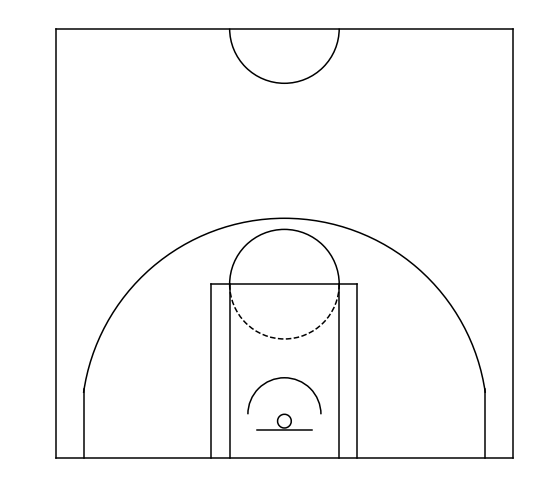

In [186]:
court, court_axis = draw_court()
court

The coordinate system returned from the `pbp` endpoint has its origin at the basket and the units of each cooridndate are feet times 10 (description [here](https://rdrr.io/github/llefebure/nba-stats/man/courtOutline.html)). For example, a 10 foot shoot from straight on would be taken from `LOC_X = 0` and `LOC_Y = 100`. Additionally, the reported `LOC_X` locations are flipped with negative values of `LOC_X` corresponding to the left side of the basket if facing it from the court. The court visual above has negative values of `LOC_X` corresponding to the right side of the basket if facing it from the court. To adjust for this, we can flip the sign on all `LOC_X` values.

In [187]:
def plot_shot(shot):
    """ plot_shot plots a shot or list of shots given in the
    shot DataFrame provided

    @param shot (DataFrame): DataFrame of shots with LOC_X and
        LOC_Y columns

    Returns

        court (maplotlib.figure.Figure): Court visual with
            the shots plotted
    """
    court, court_axis = draw_court()
    miss_df = shot[shot['etype']==2]
    make_df = shot[shot['etype']==1]

    if len(make_df)>0:
        court_axis.plot(-make_df['locX'], make_df['locY'], 'ko')
    if len(miss_df)>0:
        court_axis.plot(-miss_df['locX'], miss_df['locY'], 'kx')

    plt.close()
    return court

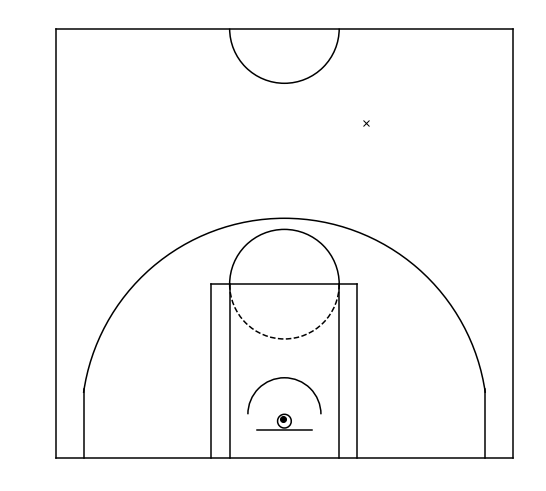

In [188]:
plot_shot(all_shots_df.loc[[4995, 74356]])

The above chart shows two shots, one with a 72.8% make probability (marked with a dot) and another with a 5.6% make probability (marked with an x). Again, this serves as a visualization to confirm that the model performs well in the extremes. A heatmap will allow for an examination of model performance from all areas. The function below, `model_heatmap`, plots the make probability of a given shot type from all locations in the halfcourt.

In [189]:
def model_heatmap(shot_type, shot_model):
    """ model_heatmap plots the make probability
    of a given shot_type from all relevant locations.

    @param shot_type (str): Shot type equal to one
        of 'DUNK', 'LAYUP', 'HOOK', or 'JUMP'

    @param shot_model (sklearn.ensemble.forest.RandomForestClassifier):
        Shot probability model
    Returns:

        heatmap (maplotlib.figure.Figure): Court visual with
            the heatmap plotted
    """

    if shot_type == 'JUMP':
        x_vals = list(range(-250, 250, 3))
        y_vals = list(range(0, 430, 3))
    else:
        x_vals = list(range(-100, 100, 1))
        y_vals = list(range(0, 100, 1))

    coordinate_vals = list(itertools.product(x_vals, y_vals))

    model_df = pd.DataFrame(coordinate_vals, columns=['locX', 'locY'])
    model_df['SHOT_DISTANCE'] = np.sqrt((model_df['locX']/10.0)**2 + (model_df['locY']/10.0)**2)
    if shot_type != 'JUMP':
        model_df = model_df[model_df['SHOT_DISTANCE']<=10]

    model_df['ANGLE'] = abs(np.rad2deg(np.arctan2(model_df['locX'],
                                                  model_df['locY'])))

    model_df['SIDE'] = [1 if x >= 0 else 0 for x in model_df['locX']]
    for shot_types in ['LAYUP', 'HOOK', 'JUMP']:
        if shot_type == shot_types:
            model_df[shot_types] = [1]*len(model_df)
        else:
            model_df[shot_types] = [0]*len(model_df)

    features_df = model_df[['SHOT_DISTANCE', 'ANGLE', 'SIDE', 'HOOK', 'LAYUP', 'JUMP']]
    model_test_preds = shot_model.predict_proba(features_df)
    model_df['shot_prob'] = [x[1] for x in model_test_preds]

    heatmap, heatmap_axis = draw_court()

    hm = heatmap_axis.scatter(-model_df['locX'], model_df['locY'],
                              c=model_df['shot_prob'], cmap='coolwarm', vmin=0, vmax=1)
    cbar = heatmap.colorbar(hm)
    cbar.set_clim(vmin=0, vmax=1)
    cbar.set_label(label='Shot Probability', fontsize=14)
    plt.title(shot_type.title() + ' Shot Probability', fontsize=14)
    plt.close()
    return heatmap

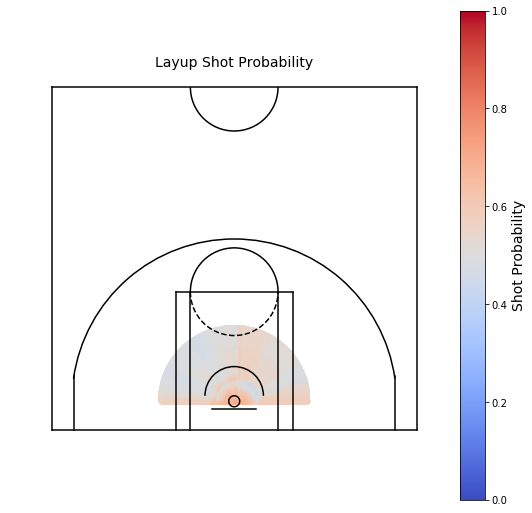

In [190]:
model_heatmap('LAYUP', rf_best)

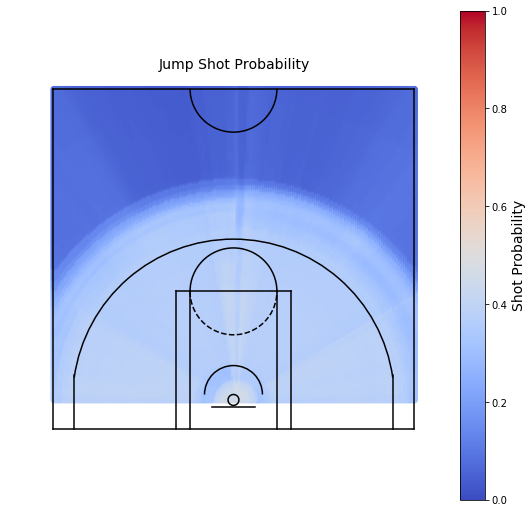

In [191]:
model_heatmap('JUMP', rf_best)

The above two charts reveal the nuance captured by the shot probability model. For a jump shot, the probability of making a shot decreases gradually as the distance from the basket increases. This provides credence to the three-point field goal revolution as the gradual decrease in shot probability is overcome by the increased value of a three-point field goal. A sharp decline in shot probability occurs well beyond the three-point line according to this model. For a layup, the probability of making a shot drops precipitously beyond the immediate vicinity of the hoop.

## Exploration

- This notebook mentions several other factors that affect shot probability but are not included in the model. Can you name more or incorporate them in a better model?
- This exercise contained several modeling assumptions, including the feature engineering choices and using a random forest model. Challenge one of these assumptions to take the analysis further.